# SCGEN:  Perturbation Prediction

In [1]:
import sys
#if branch is stable, will install via pypi, else will install from source
branch = "feature/scgen_jax"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install --quiet git+https://github.com/theislab/pertpy@$branch

In [2]:
import logging
import scanpy as sc
from pertpy.tools.jax_scgen._jax_scgen import JaxSCGEN
from pertpy.plot import scg
from scvi import REGISTRY_KEYS

Installed version 0.2.0 of pertpy is outdated. Newest version is 0.3.0!

Global seed set to 0


ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

### Loading Train Data

In [3]:
train = sc.read("./tests/data/train_kang.h5ad",
                backup_url='https://drive.google.com/uc?id=1r87vhoLLq6PXAYdmyyd89zG90eJOFYLk')

Let's remove stimulated CD4T cells from both the training set. This is just for the sake of this notebook, in practice, you do not need to do this step, just pass the train data

In [4]:
train_new = train[~((train.obs["cell_type"] == "CD4T") &
                    (train.obs["condition"] == "stimulated"))]
train_new = train_new.copy()

### Preprocessing Data

In [5]:
JaxSCGEN.setup_anndata(train_new, batch_key="condition", labels_key="cell_type")

## Creating the model¶

In [6]:
model = JaxSCGEN(train_new)

## Training the Model

In [7]:
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 26/100:  26%|████████████████████████▉                                                                       | 26/100 [09:33<27:12, 22.06s/it, v_num=1, train_loss_step=418, train_loss_epoch=2.37e+3]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 345.256. Signaling Trainer to stop.


## Saving the model

In [8]:

model.save("../saved_models/model_perturbation_prediction.pt", overwrite=True)

### Latent Space

In [9]:
latent_X = model.get_latent_representation()
latent_adata = sc.AnnData(X=latent_X, obs=train_new.obs.copy())

         Falling back to preprocessing with `sc.pp.pca` and default params.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


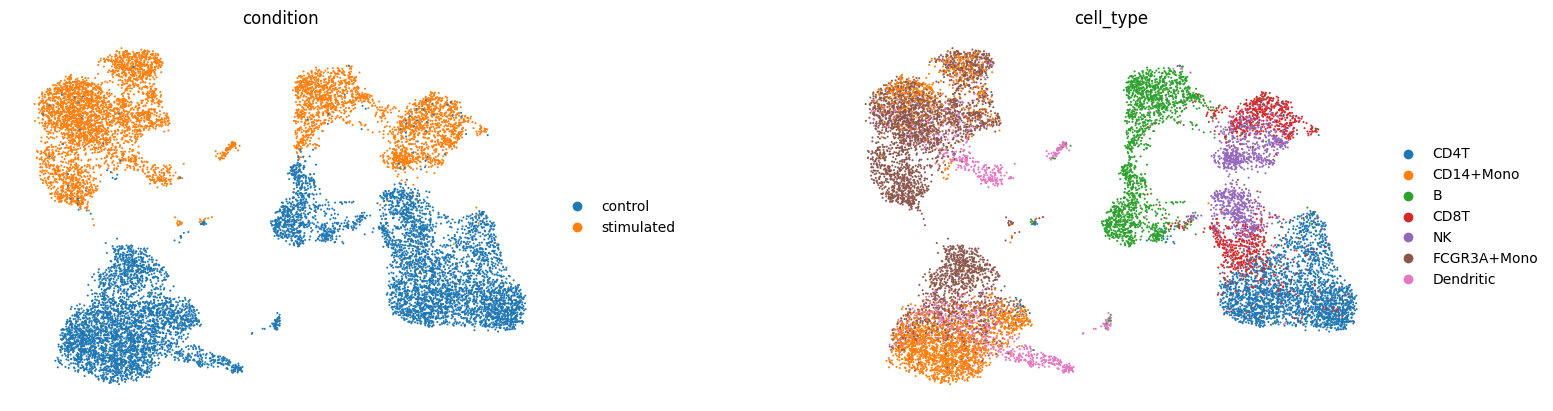

In [10]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
sc.pl.umap(latent_adata, color=['condition', 'cell_type'], wspace=0.4, frameon=False,
           save='latentspace_batch32_klw000005_z100__100e.pdf')

## Prediction

After training the model you can pass the adata of the cells you want to perturb. Here we pass unperturbed CD4T cells


Here the 'adata' contains the cells that you want estimate the perturbation based on them. we set "ctrl" to our control labels and "stim" to our stimulated labels. If you apply it in another context just set "ctrl" :"your_control_label" and "stim":"your_stimulated_label". the returned value is a numpy matrix of our predicted cells and the second one is the difference vector between our conditions which might become useful later.

In [11]:
pred, delta = model.predict(
    ctrl_key='control',
    stim_key='stimulated',
    celltype_to_predict='CD4T'
)
pred.obs['condition'] = 'pred'

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In the previous block, the difference between conditions is by default computed using all cells (obs_key="all"). However, some times you might have a rough idea that which groups (e.g. cell types) are close to your cell type of interest. This might give you more accurate predictions. For example, we can restrict the delta computation only to CD8T and NK cells. We provide dictionary in form of obs_key={"cell_type": ["CD8T", "NK"]} which is telling the model to look at "cell_type" labels in adata (here: train_new) and only compute the delta vector based on "CD8T" and "NK" cells :

pred, delta = scg.predict(adata=train_new, adata_to_predict=unperturbed_cd4t, conditions={"ctrl": "control", "stim": "stimulated"}, cell_type_key="cell_type", condition_key="condition", obs_key={"cell_type": ["CD8T", "NK"]})`

## Evaluation of the predcition¶


#### Extracting both control and real stimulated CD4T cells from our dataset

In [12]:
ctrl_adata = train[((train.obs['cell_type'] == 'CD4T') & (train.obs['condition'] == 'control'))]
stim_adata = train[((train.obs['cell_type'] == 'CD4T') & (train.obs['condition'] == 'stimulated'))]

Merging predicted cells with real ones

In [13]:
eval_adata = ctrl_adata.concatenate(stim_adata, pred)

### Embedding all real and predicted cells in one PCA plot¶

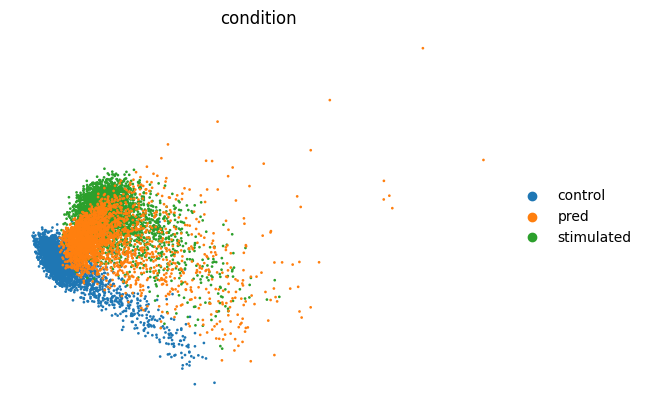

In [14]:
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False,
           save='pred_stim_b32_klw000005_z100__100e.pdf')

## Mean correlation plot¶

You can also visualize your mean gene expression of your predicted cells vs control cells while highlighting your genes of interest (here top 10 differentially expressed genes)

In [15]:
CD4T = train[train.obs["cell_type"] =="CD4T"]

In [16]:
sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["stimulated"]
print(diff_genes)

['ISG15' 'IFI6' 'ISG20' ... 'FTL' 'RGCC' 'FTH1']


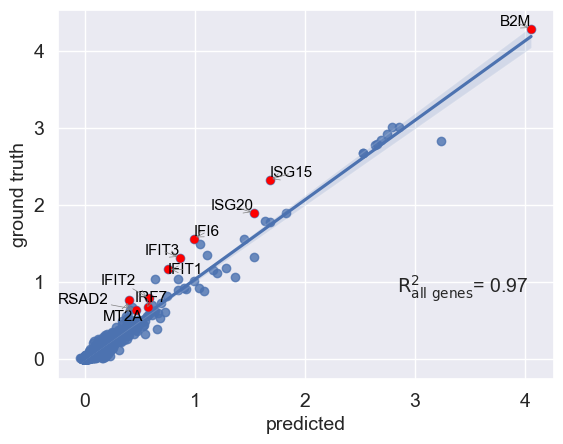

In [17]:
condition_key = model.adata_manager.get_state_registry(
    REGISTRY_KEYS.BATCH_KEY).original_key

r2_value = scg.reg_mean_plot(
    eval_adata,
    condition_key=condition_key,
    axis_keys={"x": "pred", "y": "stimulated"},
    gene_list=diff_genes[:10],
    labels={"x": "predicted", "y": "ground truth"},
    path_to_save="./reg_mean1.pdf",
    show=True,
    legend=False
)

You can also pass a list of differentially epxressed genes to compute correlation based on them

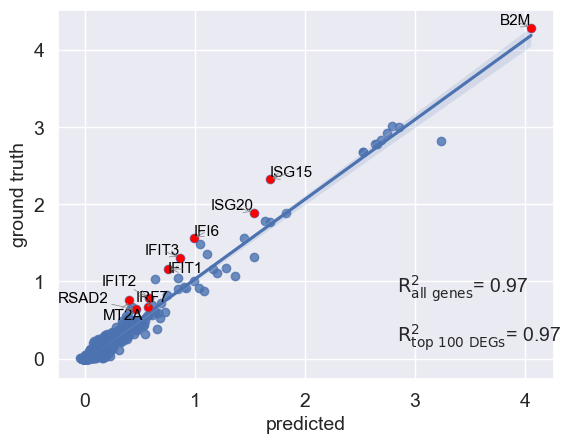

In [18]:
r2_value = model.reg_mean_plot(
    eval_adata,
    condition_key=condition_key,
    axis_keys={"x": "pred", "y": "stimulated"},
    gene_list=diff_genes[:10],
    top_100_genes= diff_genes,
    labels={"x": "predicted","y": "ground truth"},
    path_to_save="./reg_mean1.pdf",
    show=True,
    legend=False
)

### Violin plot for a specific gene¶


Let's go deeper and compare the distribution of "ISG15", the top DEG between stimulated and control CD4T cells between predcited and real cells

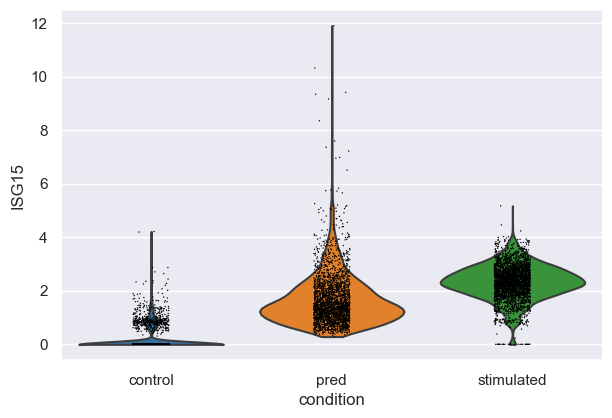

In [19]:
sc.pl.violin(eval_adata, keys="ISG15", groupby="condition")